In [73]:
# Import necessary packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import sys
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter, save_results, load_results)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring, prim, dimensional_stacking, pairs_plotting
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import ema_workbench.em_framework.samplers
from SALib.analyze import sobol
from SALib.sample import saltelli, morris, fast_sampler
import SALib.util.results
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf
from ema_workbench.util import ema_logging
from funs_project import get_opti_policies, get_selected_policies
import time
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)
from sklearn import preprocessing

[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Gorssel_10000_17-06-2021-08-58-03.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Overijssel_10000_17-06-2021-10-24-48.tar.gz


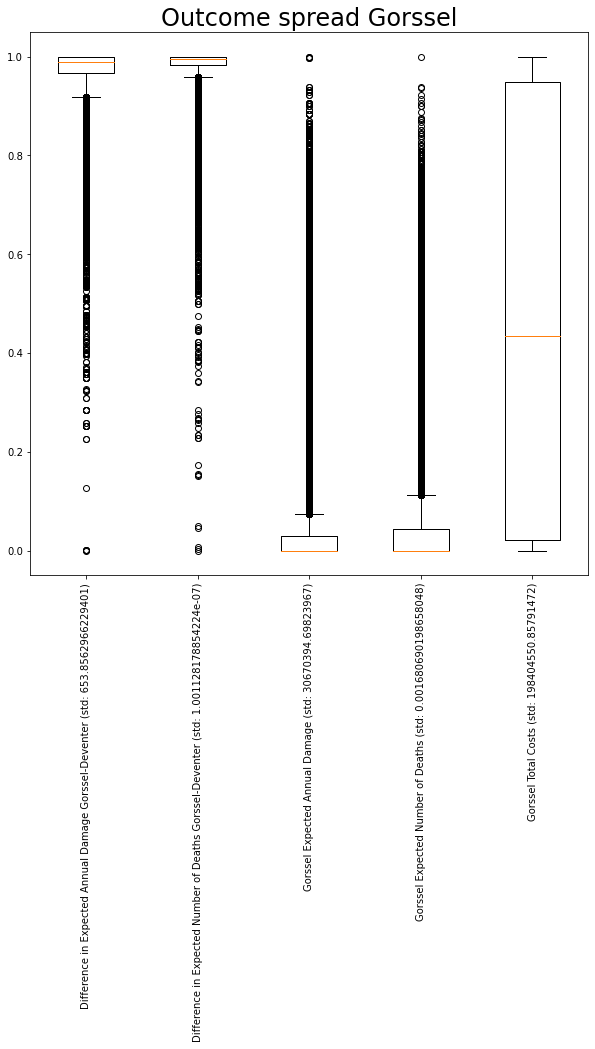

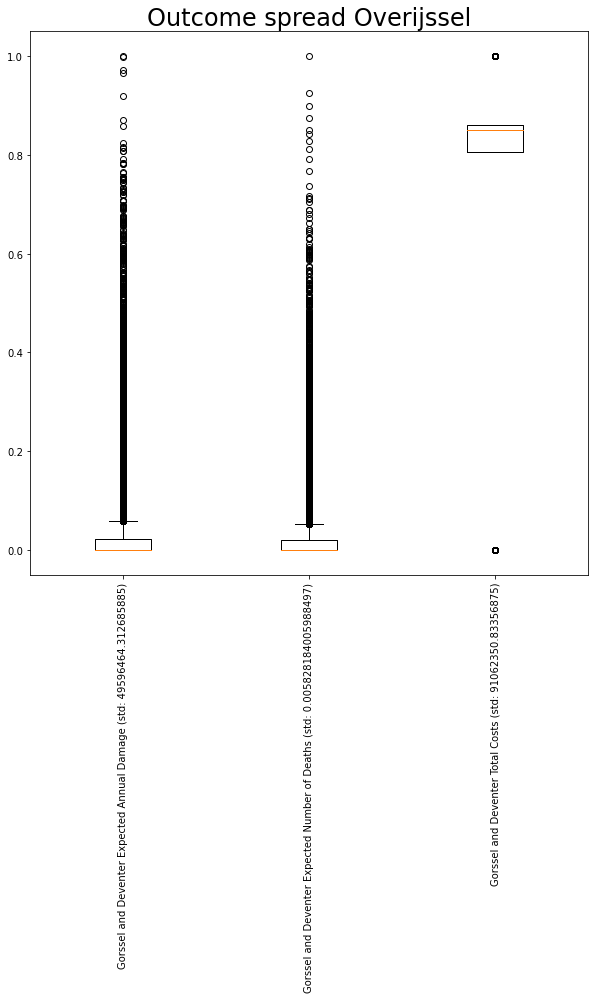

In [97]:
Gorssel = "simulation/synthesis/synthesis_Gorssel_10000_17-06-2021-08-58-03.tar.gz"
Overijssel = "simulation/synthesis/synthesis_Overijssel_10000_17-06-2021-10-24-48.tar.gz"

paths = {'Gorssel':Gorssel, 'Overijssel':Overijssel}

actors = ['Gorssel', 'Overijssel']

for actor in actors:
    x, y = load_results(paths[actor])
    y_array = pd.DataFrame(y).values

    min_max_scaler = preprocessing.MinMaxScaler()
    y_scaled = min_max_scaler.fit_transform(y_array)

    data = pd.DataFrame(y_scaled)
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.boxplot(data)
    ax.set_title('Outcome spread '+ actor, fontsize=24)
    xticks = [key + ' (std: ' + str(np.std(pd.DataFrame(y)[key])) + ')' for key in list(y.keys())]
    plt.xticks([i + 1 for i in range(len(data.columns))], xticks, rotation=90)

    plt.savefig('../../report/figures/results/outcome_spread_' + actor + '.png')

['Gorssel and Deventer Expected Annual Damage',
 'Gorssel and Deventer Expected Number of Deaths',
 'Gorssel and Deventer Total Costs']

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]


[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Overijssel_10000_17-06-2021-10-24-48.tar.gz


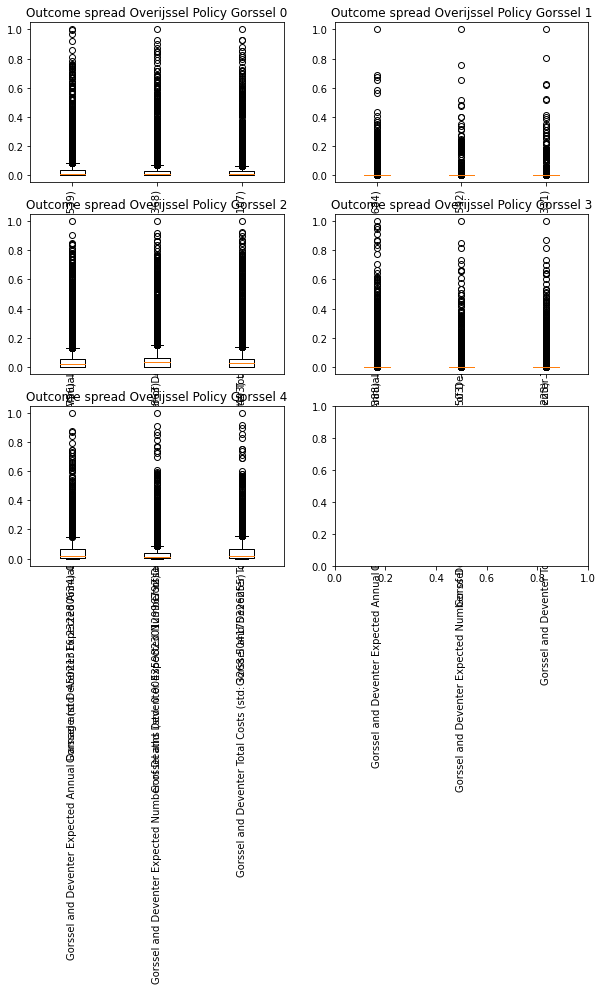

In [145]:
Gorssel = "simulation/synthesis/synthesis_Gorssel_10000_17-06-2021-08-58-03.tar.gz"
Overijssel = "simulation/synthesis/synthesis_Overijssel_10000_17-06-2021-10-24-48.tar.gz"

paths = {'Gorssel':Gorssel, 'Overijssel':Overijssel}

actor = 'Overijssel'

   
fig, ax = plt.subplots(3,2, figsize=(10,10))

print(ax.flatten())

experiments, outcomes = load_results(paths[actor])

outcomes = pd.DataFrame(outcomes)

columns = list(outcomes.columns)

columns.append('policy')

y_df = pd.concat([experiments, outcomes], axis=1)[columns]


for i, policy in enumerate(y_df['policy'].unique()):

    y = y_df[y_df['policy']==policy]


    new_y = pd.DataFrame(y).drop(columns=['policy'])
    y_array = new_y.values

    min_max_scaler = preprocessing.MinMaxScaler()
    y_scaled = min_max_scaler.fit_transform(y_array)

    data = pd.DataFrame(y_scaled)

    ax.flatten()[i].boxplot(data)
    ax.flatten()[i].set_title('Outcome spread '+ actor + ' ' + str(policy), fontsize=12)
    xticks = [key + ' (std: ' + str(np.std(new_y)[key]) + ')' for key in list(new_y.columns)]
    ax.flatten()[i].set_xticklabels(xticks, rotation=90)

    #plt.savefig('../../report/figures/results/outcome_spread_' + actor + '.png')

In [127]:
actor = 'Gorssel'

experiments, outcomes = load_results(paths[actor])
    
outcomes = pd.DataFrame(outcomes)

columns = list(outcomes.columns)

columns.append('policy')

y_df = pd.concat([experiments, outcomes], axis=1)[columns]

#y_df[y_df['policy']=='Policy Gorssel 0']

list(y_df['policy'].unique())

[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Gorssel_10000_17-06-2021-08-58-03.tar.gz


['Policy Deventer 0',
 'Policy Deventer 1',
 'Policy Deventer 2',
 'Policy Deventer 3',
 'Policy Deventer 4',
 'Policy Overijssel 0',
 'Policy Overijssel 1',
 'Policy Overijssel 2',
 'Policy Overijssel 3',
 'Policy Overijssel 4']

In [107]:
list(outcomes.columns)

['Gorssel and Deventer Expected Annual Damage',
 'Gorssel and Deventer Expected Number of Deaths',
 'Gorssel and Deventer Total Costs']

In [116]:
experiments.shape

(50000, 53)

In [117]:
outcomes.shape

(50000, 3)